In [23]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import scipy.stats as stats

import joblib

### Loading the test data

In [24]:
# Load the test set
data = pd.read_csv("test.csv")

print(data.shape)
print(data.head())

# drop the id variable
data = data.drop("Id", axis=1)

(1459, 80)
     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0    

### Feature engineering

In [25]:
# Categorical values

# Hardcoded categorical variables with missing tag
with_string_missing = ['Alley', 'FireplaceQu',
                       'PoolQC', 'Fence', 'MiscFeature']

# Hardcoded categorical variables and most frequent tag
with_frequent_category = {
    'MasVnrType': 'None',
    'BsmtQual': 'TA',
    'BsmtCond': 'TA',
    'BsmtExposure': 'No',
    'BsmtFinType1': 'Unf',
    'BsmtFinType2': 'Unf',
    'Electrical': 'SBrkr',
    'GarageType': 'Attchd',
    'GarageFinish': 'Unf',
    'GarageQual': 'TA',
    'GarageCond': 'TA',
}

# replace missing values with new label: "Missing"
data[with_string_missing] = data[with_string_missing].fillna("Missing")

# replace missing values with the most frequent category
for var in with_frequent_category.keys():
    data[var] = data[var].fillna(with_frequent_category[var])

In [26]:
# Numerical values

# Hardcoded mean values for NaNs
vars_with_na = {
    "LotFrontage": 69.87974098057354,
    "MasVnrArea": 103.7974006116208,
    "GarageYrBlt": 1978.2959677419356,
}

# replace these missing values
for var in vars_with_na.keys():
    # binary missing indicator
    data[var + "_na"] = np.where(data[var].isnull(), 1, 0)
    
    # mean impute missing values
    data[var] = data[var].fillna(vars_with_na[var])

In [27]:
# Temporal variables

def elapsed_years(df, var):
    df[var] = df['YrSold'] - df[var]
    return df

# calculate time delta
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    data = elapsed_years(data, var)
    
# drop the YrSold column
data = data.drop("YrSold", axis=1)

### Feature transformation

In [28]:
# Numerical variables

# log transformation
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    data[var] = np.log(data[var])
    
# Hardcoded Yeo-Johnson
data['LotArea'] = stats.yeojohnson(data['LotArea'], lmbda=-12.55283001172003)

# Binarize skewed variables
skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

# map the variable values into 0 and 1skewed:
data[var] = np.where(data[var]==0, 0, 1)

In [29]:
# Categorical variables

# Hardcoded quality mappings
qual_mappings = {'Po': 1, 'Fa': 2,
                 'TA': 3, 'Gd': 4,
                 'Ex': 5, 'Missing': 0,
                 'NA': 0}

qual_vars = ['ExterQual', 'ExterCond',
             'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual',
             'FireplaceQu', 'GarageQual',
             'GarageCond',
            ]

# map the quality variables to numbers
for var in qual_vars:
    data[var] = data[var].map(qual_mappings)
    
    
# Hardcoded exposure mappings
exposure_mappings = {'No': 1, 'Mn': 2,
                     'Av': 3, 'Gd': 4}

var = 'BsmtExposure'

data[var] = data[var].map(exposure_mappings)

# Hardcoded finish mappings
finish_mappings = {'Missing': 0, 'NA': 0,
                   'Unf': 1, 'LwQ': 2,
                   'Rec': 3, 'BLQ': 4,
                   'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

for var in finish_vars:
    data[var] = data[var].map(finish_mappings)
    
# Hardcoded garage mappings
garage_mappings = {'Missing': 0, 'NA': 0,
                   'Unf': 1, 'RFn': 2,
                   'Fin': 3}

var = 'GarageFinish'

data[var] = data[var].map(garage_mappings)


# Hardcoded fence mappings
fence_mappings = {'Missing': 0, 'NA': 0,
                  'MnWw': 1, 'GdWo': 2,
                  'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

data[var] = data[var].map(fence_mappings)

In [30]:
# Check if there are still NaNs
with_null = [var for var in data.columns if data[var].isna().sum() > 0]

print(with_null)

['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageCars', 'GarageArea', 'SaleType']


New data has a lot of new NaN values that were not in the training set

### Removing rare labels

In [31]:
# Hardcoded rare labels
frequent_ls = {
    'MSZoning': ['FV', 'RH', 'RL', 'RM'],
    'Street': ['Pave'],
    'Alley': ['Grvl', 'Missing', 'Pave'],
    'LotShape': ['IR1', 'IR2', 'Reg'],
    'LandContour': ['Bnk', 'HLS', 'Low', 'Lvl'],
    'Utilities': ['AllPub'],
    'LotConfig': ['Corner', 'CulDSac', 'FR2', 'Inside'],
    'LandSlope': ['Gtl', 'Mod'],
    'Neighborhood': ['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
                     'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
                     'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
                     'Somerst', 'StoneBr', 'Timber'],

    'Condition1': ['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'],
    'Condition2': ['Norm'],
    'BldgType': ['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'],
    'HouseStyle': ['1.5Fin', '1Story', '2Story', 'SFoyer', 'SLvl'],
    'RoofStyle': ['Gable', 'Hip'],
    'RoofMatl': ['CompShg'],
    'Exterior1st': ['AsbShng', 'BrkFace', 'CemntBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'],

    'Exterior2nd': ['AsbShng', 'BrkFace', 'CmentBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'Wd Shng'],

    'MasVnrType': ['BrkFace', 'None', 'Stone'],
    'Foundation': ['BrkTil', 'CBlock', 'PConc', 'Slab'],
    'Heating': ['GasA', 'GasW'],
    'CentralAir': ['N', 'Y'],
    'Electrical': ['FuseA', 'FuseF', 'SBrkr'],
    'Functional': ['Min1', 'Min2', 'Mod', 'Typ'],
    'GarageType': ['Attchd', 'Basment', 'BuiltIn', 'Detchd'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['Missing'],
    'MiscFeature': ['Missing', 'Shed'],
    'SaleType': ['COD', 'New', 'WD'],
    'SaleCondition': ['Abnorml', 'Family', 'Normal', 'Partial'],
    'MSSubClass': ['20', '30', '50', '60', '70', '75', '80', '85', '90', '120', '160', '190'],
}


# Apply the mappings
for var in frequent_ls.keys():
    data[var] = np.where(data[var].isin(
        frequent_ls), data[var], 'Rare')

In [32]:
# Encoding of categorical variables

# Hardcoded mappings
ordinal_mappings = {
    'MSZoning': {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4},
    'Street': {'Rare': 0, 'Pave': 1},
    'Alley': {'Grvl': 0, 'Pave': 1, 'Missing': 2},
    'LotShape': {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3},
    'LandContour': {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3},
    'Utilities': {'Rare': 0, 'AllPub': 1},
    'LotConfig': {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4},
    'LandSlope': {'Gtl': 0, 'Mod': 1, 'Rare': 2},
    'Neighborhood': {'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'Edwards': 3,
                     'BrkSide': 4, 'OldTown': 5, 'Sawyer': 6, 'SWISU': 7,
                     'NAmes': 8, 'Mitchel': 9, 'SawyerW': 10, 'Rare': 11,
                     'NWAmes': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15,
                     'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19,
                     'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22},
    
    'Condition1': {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'RRAn': 3, 'Rare': 4, 'PosN': 5},
    'Condition2': {'Rare': 0, 'Norm': 1},
    'BldgType': {'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, '1Fam': 3, 'TwnhsE': 4},
    'HouseStyle': {'SFoyer': 0, '1.5Fin': 1, 'Rare': 2, '1Story': 3, 'SLvl': 4, '2Story': 5},
    'RoofStyle': {'Gable': 0, 'Rare': 1, 'Hip': 2},
    'RoofMatl': {'CompShg': 0, 'Rare': 1},
    'Exterior1st': {'AsbShng': 0, 'Wd Sdng': 1, 'WdShing': 2, 'MetalSd': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CemntBd': 9, 'VinylSd': 10},
    
    'Exterior2nd': {'AsbShng': 0, 'Wd Sdng': 1, 'MetalSd': 2, 'Wd Shng': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CmentBd': 9, 'VinylSd': 10},
    
    'MasVnrType': {'Rare': 0, 'None': 1, 'BrkFace': 2, 'Stone': 3},
    'Foundation': {'Slab': 0, 'BrkTil': 1, 'CBlock': 2, 'Rare': 3, 'PConc': 4},
    'Heating': {'Rare': 0, 'GasW': 1, 'GasA': 2},
    'CentralAir': {'N': 0, 'Y': 1},
    'Electrical': {'Rare': 0, 'FuseF': 1, 'FuseA': 2, 'SBrkr': 3},
    'Functional': {'Rare': 0, 'Min2': 1, 'Mod': 2, 'Min1': 3, 'Typ': 4},
    'GarageType': {'Rare': 0, 'Detchd': 1, 'Basment': 2, 'Attchd': 3, 'BuiltIn': 4},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
    'PoolQC': {'Missing': 0, 'Rare': 1},
    'MiscFeature': {'Rare': 0, 'Shed': 1, 'Missing': 2},
    'SaleType': {'COD': 0, 'Rare': 1, 'WD': 2, 'New': 3},
    'SaleCondition': {'Rare': 0, 'Abnorml': 1, 'Family': 2, 'Normal': 3, 'Partial': 4},
    'MSSubClass': {'30': 0, 'Rare': 1, '190': 2, '90': 3, '160': 4, '50': 5, '85': 6,
                   '70': 7, '80': 8, '20': 9, '75': 10, '120': 11, '60': 12},
}


# Apply the mappings
for var in ordinal_mappings.keys():

    ordinal_label = ordinal_mappings[var]
    data[var] = data[var].map(ordinal_label)

In [33]:
# Check if there are NaN values
with_null = [var for var in data.columns if data[var].isnull().sum() > 0]

len(with_null)

14

In [34]:
# Dirty solution
data = data.fillna(0)

### Feature scaling

In [35]:
# import the min-max scaler
scaler = joblib.load('minmax_scaler.joblib') 

# scaled dataset
data = pd.DataFrame(
    scaler.transform(data),
    columns=data.columns
)

In [36]:
# Load the pre-selected features

features = pd.read_csv('selected_features.csv')
features = features['0'].to_list() 

# reduce the train and test set to the selected features
data = data[features]

### Making predictions

<Axes: >

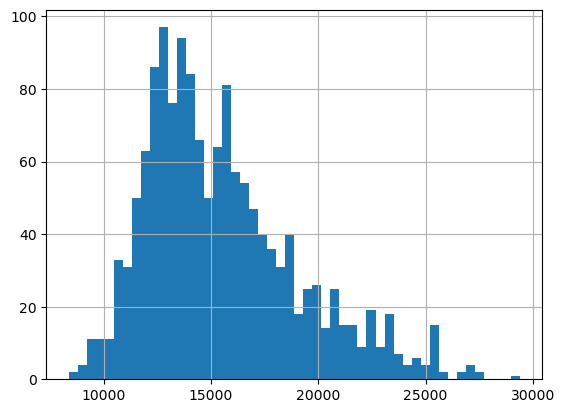

In [38]:
# Pre-trained model
lin_model = joblib.load('lasso_regression.joblib') 

# make predictions
pred = lin_model.predict(data)

# plot the predicted sale prices
pd.Series(np.exp(pred)).hist(bins=50)